### Full Name : Radin Khayyam
### Student Number : 99101579


# Support Vector Machines (SVM)

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import warnings
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

## Goal
In this assignment, we are going to implement Support Vector Machines (SVM) algorithm that determines which patient is in danger and which is not.

In [153]:
df = pd.read_csv("/kaggle/input/liver-disease/Liver_Disease.csv") 

### Pre-Processing

#### Exploratory Data Analysis:
In statistics, exploratory data analysis is an approach to analyze datasets to summarize their main characteristics, often using statistical graphics and other data visualization methods.

This is a general approach that should be applied when you encounter a dataset.

Shape of the dataset: (583, 11)
Missing entries in each column:
 Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
label                         0
dtype: int64
Target Variable Distribution:
 label
1    0.713551
2    0.286449
Name: proportion, dtype: float64


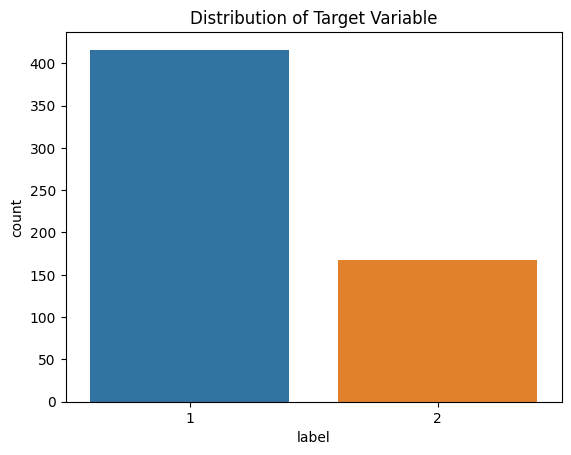

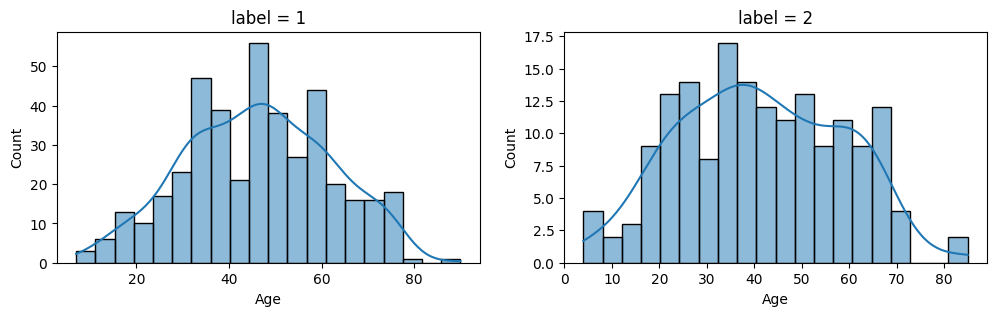

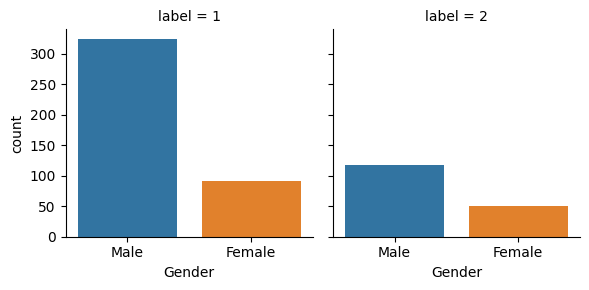

In [154]:
###############################################################################
## TODO: Find the shape of the dataset.                                      ##
###############################################################################
print("Shape of the dataset:", df.shape)
print("==========================================================")
###############################################################################
## TODO: Check if there is missing entries in the dataset columnwise.        ##
###############################################################################
print("Missing entries in each column:\n", df.isnull().sum())
print("==========================================================")
###############################################################################
## TODO: Check whether the dataset is balanced or not.                       ##
###############################################################################
print("Target Variable Distribution:\n", df['label'].value_counts(normalize=True))
sns.countplot(data=df, x='label')
plt.title("Distribution of Target Variable")
plt.show()
print("==========================================================")
###############################################################################
## TODO: plot the age distirbution and gender distrbution for both group    ##
## of patients.(4 plots)                                                    ##
###############################################################################
# Plot age and gender distributions for each group (danger vs. not in danger)
warnings.filterwarnings("ignore", category=FutureWarning)

plt.figure(figsize=(12, 3))

# Age distribution for patients not in danger (label = 1)
plt.subplot(1, 2, 1)
sns.histplot(data=df[df['label'] == 1], x='Age', bins=20, kde=True)
plt.title("label = 1")

# Age distribution for patients in danger (label = 2)
plt.subplot(1, 2, 2)
sns.histplot(data=df[df['label'] == 2], x='Age', bins=20, kde=True)
plt.title("label = 2")

# Gender distribution for patients with different labels

g = sns.catplot(x = 'Gender', col = 'label', data = df, kind = "count", order = ["Male", "Female"], height=3 , aspect=1)

plt.tight_layout()
plt.show()

##### Question: What do you conclude from the plots?

The plots indicate that the dataset is imbalanced, with a higher proportion of patients in the label = 1 group (about 71.4%) compared to the label = 2 group (28.6%). This imbalance could affect model performance, requiring techniques such as resampling or class weighting. Age distribution shows a wider spread across ages for both groups, though slightly younger ages appear more frequently in the label = 1 group. Additionally, the gender distribution reveals a higher proportion of males in both groups, particularly in label = 1, suggesting a potential gender-related pattern in the data.

#### Outlier Detection & Removal
Check whether we have outliers in the data. If there are, delete them.

In [155]:
################################################################################
## TODO
################################################################################
# define a function to detect and remove outliers using the IQR method
def remove_outliers(df, columns, threshold):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Filtering out the outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# list of continuous columns to check for outliers
continuous_columns = ['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 
                      'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 
                      'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio']

# remove outliers
df_cleaned = remove_outliers(df, continuous_columns, 5)

print("Shape of the dataset after removing outliers:", df_cleaned.shape)

Shape of the dataset after removing outliers: (485, 11)


#### Feature Engineering:
Sometimes the collected data are raw; they are either incompatible with your model or hinders its performance. That’s when feature engineering comes to rescue. It encompasses preprocessing techniques to compile a dataset by extracting features from raw data.
also feel free to do more feature engineering techniques if needed.

In [156]:
################################################################################
## TODO: Normalize numerical features to be between 0 and 1                   ##
## Note that just numerical fetures should be normalized.                     ##
################################################################################
# list of numerical columns to normalize
numerical_columns = ['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 
                     'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 
                     'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio']

scaler = MinMaxScaler()
df_cleaned[numerical_columns] = scaler.fit_transform(df_cleaned[numerical_columns])
# Convert categorical columns to numeric
df_cleaned = pd.get_dummies(df_cleaned, columns=['Gender'], drop_first=True)
print(df_cleaned.head())

        Age  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
0  0.709302         0.029412          0.000000              0.155194   
2  0.674419         0.676471          0.816327              0.534418   
3  0.627907         0.058824          0.061224              0.148936   
4  0.790698         0.343137          0.387755              0.165207   
5  0.488372         0.137255          0.122449              0.181477   

   Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  \
0                  0.029557                    0.033333        0.594203   
2                  0.246305                    0.241667        0.623188   
3                  0.019704                    0.041667        0.594203   
4                  0.083744                    0.204167        0.666667   
5                  0.044335                    0.016667        0.710145   

    Albumin  Albumin_and_Globulin_Ratio  label  Gender_Male  
0  0.521739                     0.37500      1        

### SVM

#### spliting data

In [167]:
## TODO Split the data into test and training sets.

X = df_cleaned.drop(columns=['label'])
y = df_cleaned['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (388, 10)
Test set shape: (97, 10)


### SVM using Scikit-Learn:
First of all train an svm model with default parameters and report its.

In [158]:
#########################################################################################
## TODO
#########################################################################################

svm_model = SVC()

svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

# calculate and print the performance metrics
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6391752577319587


#### Grid Search
Use Grid search and validation set to find the best parameters for your SVM model.

In [159]:
#########################################################################################
## TODO
#########################################################################################
# define the parameter grid for SVM
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],          # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
}

# initialize the SVM model
svm_model = SVC()

# set up the Grid Search with cross-validation
grid_search = GridSearchCV(svm_model, param_grid, scoring='accuracy')

# fit grid search on the training set
grid_search.fit(X_train, y_train)

# get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'C': 0.01, 'kernel': 'linear'}
Best Accuracy: 0.67012987012987


Train an svm model on the entire training data using the parameters you found in the previous step.

In [160]:
#########################################################################################
## TODO
#########################################################################################
# train the SVM model with the best parameters on the full training set
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train, y_train)

y_pred = best_svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6391752577319587


### Confusion Matrix
Plot the confusion matrix and report the model accuracy on test set.
What does each entry of the confusion matrix mean?

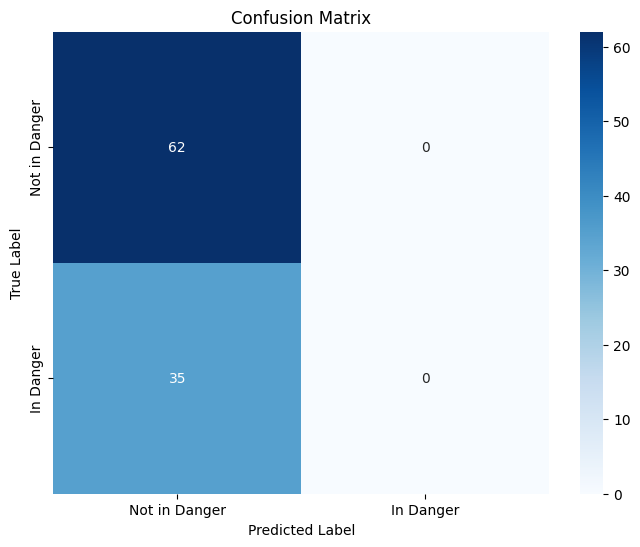

In [161]:
#########################################################################################
## TODO
#########################################################################################
# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not in Danger', 'In Danger'], yticklabels=['Not in Danger', 'In Danger'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Add some outliers to the dataset, train an SVM and logistic regression model, and compare the results.

In [174]:
#########################################################################################
## TODO
#########################################################################################

def add_outliers(df, columns, proportion=0.2, magnitude=10):
    df_outliers = df.copy()
    num_outliers = int(len(df) * proportion)
    np.random.seed(42)
    
    for col in columns:
        outlier_indices = np.random.choice(df.index, num_outliers, replace=False)
        df_outliers.loc[outlier_indices, col] = df_outliers[col] * magnitude  # Inflate values by magnitude
    
    return df_outliers

# Columns to add outliers to
columns_with_outliers = ['Total_Bilirubin', 'Alamine_Aminotransferase', 'Age']
df_outliers = add_outliers(df_cleaned, columns_with_outliers)


X = df_outliers.drop(columns=['label'])
y = df_outliers['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm_model = SVC()
log_reg_model = LogisticRegression(max_iter=1000)

svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Train the Logistic Regression model
log_reg_model.fit(X_train, y_train)
y_pred_log_reg = log_reg_model.predict(X_test)

# Step 5: Evaluate and Compare Performance
print("SVM Model Performance with Outliers")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))


print("\nLogistic Regression Model Performance with Outliers")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))


SVM Model Performance with Outliers
Accuracy: 0.6288659793814433

Logistic Regression Model Performance with Outliers
Accuracy: 0.6391752577319587


The Logistic Regression model achieved a better result.